 # Find out the market value of your car 

We work for 'Rusty Bargain', a second-hand car sales service that is developing an app to attract new customers. Thanks to this app, you can quickly find out the market value of your car.

## Contents <a id='back'></a>

* [Intro](#intro)
* [Stage 1. Data loading](#1)
    * [1.1 Data exploration](#1.1)
    * [1.2 Graphical data exploration](#1.2)
* [Stage 2. Data preprocessing](#2)
* [Stage 3. Model training](#3)
    * [3.1 DecisionTreeRegressor](#3.1)
    * [3.2 RandomForestRegressor](#3.2)
    * [3.3 LinearRegression](#3.3)
* [Stage 4. Gradient boosting](#4)
    * [4.1 CatBoost](#4.1)
    * [4.2 XGBoost](#4.2)
    * [4.3 LightGBM](#4.3)
* [Conclusion](#conclusion)

## Introduction <a id='intro'></a>

As mentioned, we work for a 2nd hand car sales service that is developing an app that predicts the value of your car. In order to develop this app, we have access to the history, technical specifications, equipment versions and prices. We are interested to optimize:
- the quality of the prediction
- the speed of the prediction
- the time required for training

## Stage 1. Data loading <a id='1'></a>

In [1]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
# Load the data files into DataFrame
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/car_data.csv')
except:
    df = pd.read_csv('/datasets/car_data.csv')

### 1.1 Data exploration <a id='1.1'></a>

In [3]:
# printing the general/summary information and first rows of df
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


The dataset contains the following fields:
- `DateCrawled` — date the profile was downloaded from the database
- `Price` — (€)
- `VehicleType` — vehicle body type
- `RegistrationYear` — vehicle registration year
- `Gearbox` — gearbox type
- `Power` — power (hp)
- `Model` — vehicle model
- `Mileage` — mileage (kilometers)
- `RegistrationMonth` — vehicle registration month
- `FuelType` 
- `Brand`
- `NotRepaired` — vehicle with or without repair
- `DateCreated` — profile creation date
- `NumberOfPictures` — number of vehicle photos
- `PostalCode` — postal code of the profile owner (user)
- `LastSeen` — date the user was last active

The column 'Price' is the target

### 1.2 Graphical data exploration <a id='1.2'></a>

Lets see what feature has more "weight" on the target, in our case the variable "price". So we use a correlation matrix to do it:

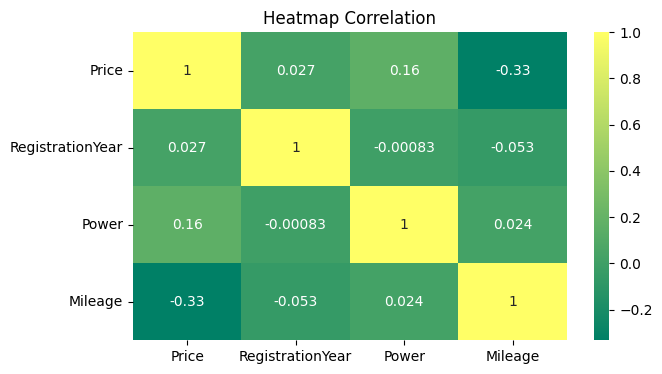

In [4]:
# correlation matrix
plt.figure(figsize = (7,4))
df_corr = df.drop(['DateCrawled', 'VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
sns.heatmap(df_corr.corr(), annot = True, cmap = 'summer')
plt.title('Heatmap Correlation')
plt.show()

Ok, although the correlations are pretty samll, it does make sense because price increase when:
- registration year increase
- power increase
- mileage decrease

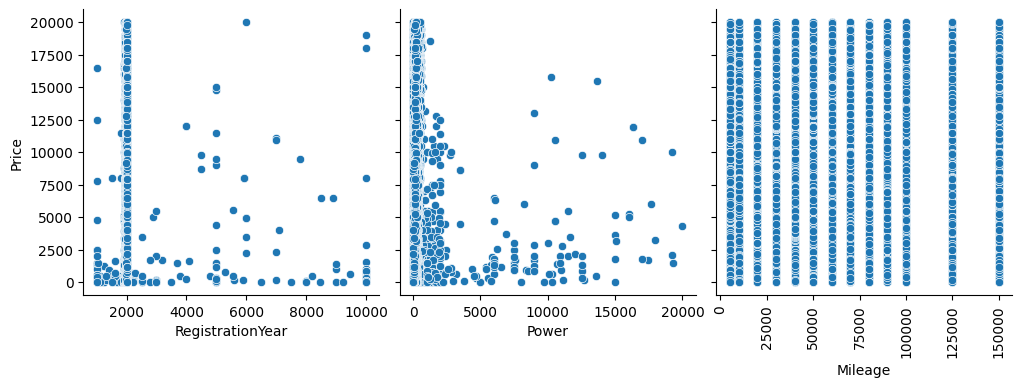

In [5]:
sns.pairplot(df, x_vars=['RegistrationYear', 'Power', 'Mileage',], y_vars='Price', height=3.5, aspect=1, kind='scatter')
plt.xticks(rotation= 90)
plt.show()

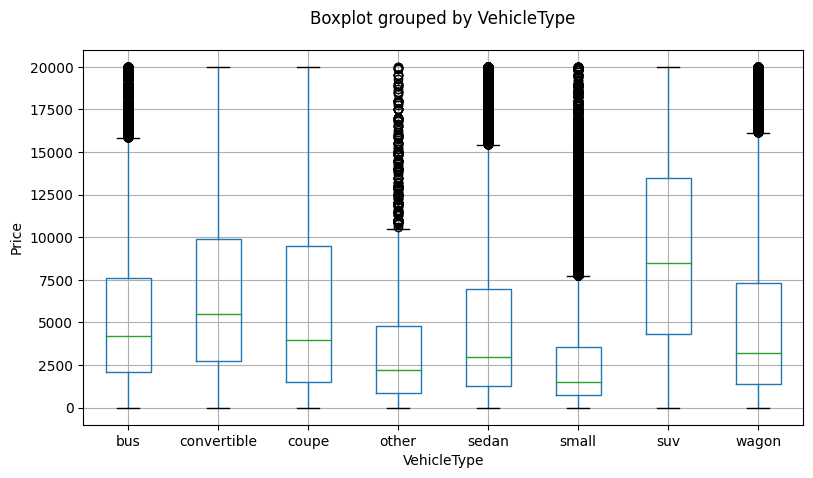

In [6]:
df.boxplot(column='Price', by=['VehicleType'], figsize=(9, 5))
plt.title('')
plt.xlabel('VehicleType')
plt.ylabel('Price')
plt.show()

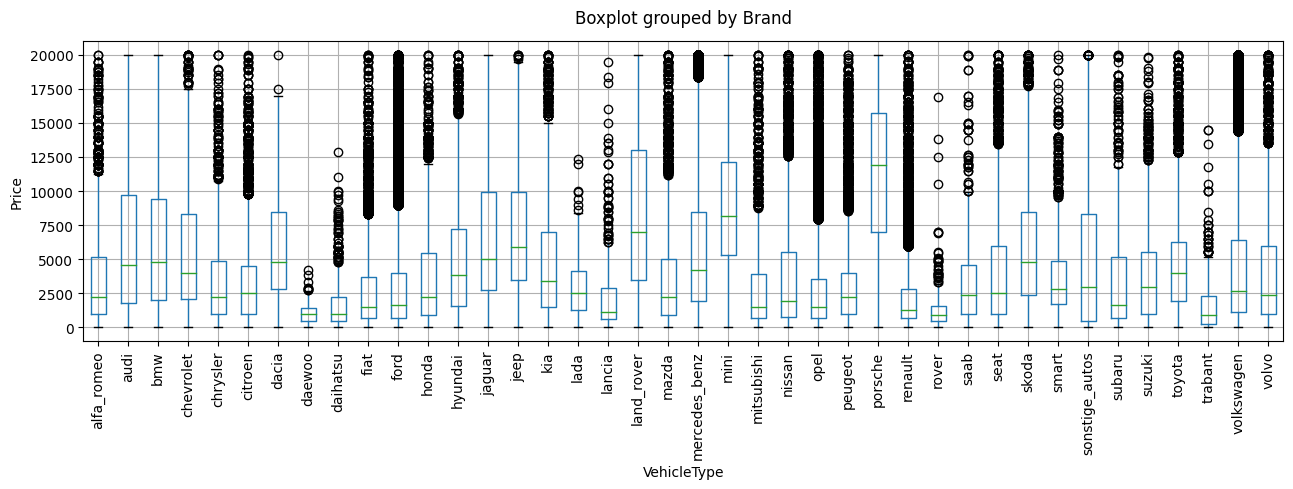

In [7]:
df.boxplot(column='Price', by=['Brand'], figsize=(15, 4))
plt.title('')
plt.xlabel('VehicleType')
plt.ylabel('Price')
plt.xticks(rotation= 90)
plt.show()

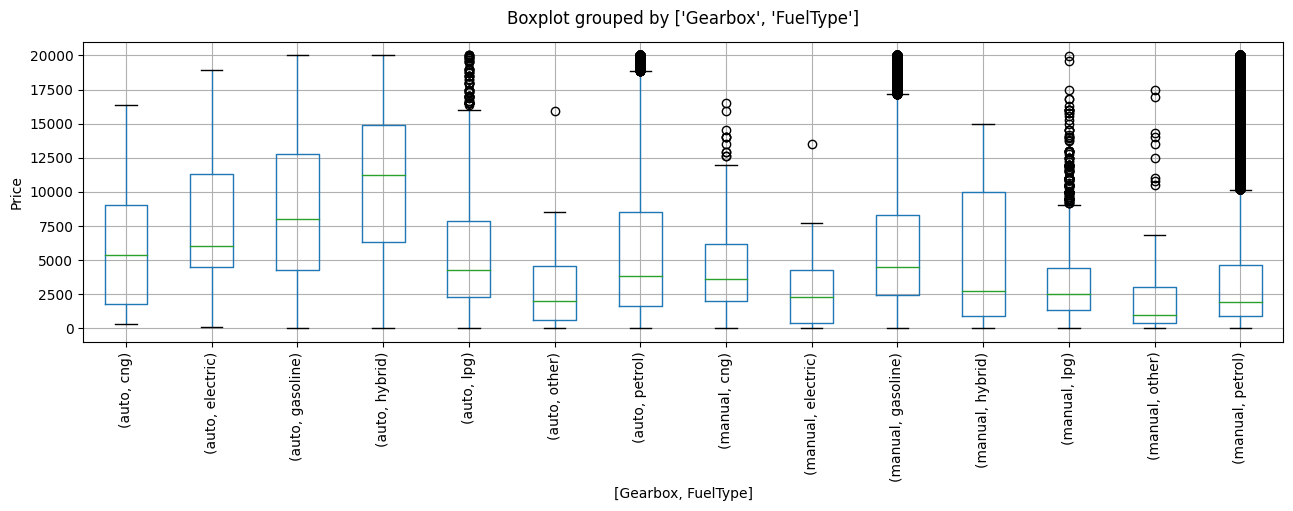

In [8]:
df.boxplot(column='Price', by=['Gearbox', 'FuelType'], figsize=(15, 4))
plt.title('')
# plt.xlabel("Gearbox, FuelType")
plt.ylabel('Price')
plt.xticks(rotation= 90)
plt.show()

## Stage 2. Data preprocessing <a id='2'></a>

In [9]:
# rename Pandas columns to lower case
df.columns= df.columns.str.lower()

In [10]:
df.isna().sum()

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
mileage                  0
registrationmonth        0
fueltype             32895
brand                    0
notrepaired          71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

Now, we have to try to fill as much as possible the null values column by column. Let's start with 'vehicletype':

We want to replace the null values with the most common value in each group based on 'model' and 'brand'. If mode 'model'too is null, we will set 'vehicletype' to 'unknown'

In [11]:
df.loc[df['vehicletype'].isna(), 'vehicletype'] = df.groupby(['model','brand'])['vehicletype'].transform(lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN')
df['vehicletype'].fillna('unknown', inplace = True)

The null values in column 'model' will be replaces with a new category 'unknown'

In [12]:
# replacing null values with 'unknown' in column 'model'
df['model'].fillna('unknown', inplace = True)

We do the same to fill the null values in 'gearbox' and 'fueltype':

In [13]:
df.loc[df['gearbox'].isna(), 'gearbox'] = df.groupby(['model','brand'])['gearbox'].transform(lambda x: x.mode()[0] if any(x.mode()) else np.nan)
df.loc[df['fueltype'].isna(), 'fueltype'] = df.groupby(['model','brand'])['fueltype'].transform(lambda x: x.mode()[0] if any(x.mode()) else np.nan)

Now, we only miss the 'notrepaired' column. To fill its null values the most valid idea is to group by 'model','brand', 'mileage', 'registrationyear'. We do this in two steps:

In [14]:
df.loc[df['notrepaired'].isna(), 'notrepaired'] = df.groupby(['model', 'brand', 'registrationyear'])['notrepaired'].transform(lambda x: x.mode()[0] if any(x.mode()) else np.nan)
df.loc[df['notrepaired'].isna(), 'notrepaired'] = df.groupby(['model', 'mileage'])['notrepaired'].transform(lambda x: x.mode()[0] if any(x.mode()) else np.nan)

We have no more choice than create a new category for the rows with null value in 'notrepaired'. We call it 'unknown'

In [15]:
# replacing null values with 'unknown' in column 'model'
df['notrepaired'].fillna('unknown', inplace = True)

Cool, we have now no more missing values in all dataframe

In [16]:
# counting the obvious duplicate 
df.duplicated().sum()

301

So there are 301 duplicated rows. We discard the duplicated keeping the first and reset the index.

In [17]:
df.drop_duplicates(keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

For our work we do not need to know the columns 'datecrawled', 'datecreated', 'lastseen', 'numberofpictures' and 'postalcode'. Even 'registrationmonth' is not really needed. We can discard all of them:

In [18]:
df.drop(['datecrawled', 'registrationmonth', 'datecreated', 'lastseen', 'numberofpictures', 'postalcode'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [19]:
# analyzing the descriptive statistics
df._get_numeric_data().describe().astype(int)

,price,registrationyear,power,mileage
count,354068,354068,354068,354068
mean,4416,2004,110,128211
std,4514,90,189,37907
min,0,1000,0,5000
25%,1050,1999,69,125000
50%,2700,2003,105,150000
75%,6400,2008,143,150000
max,20000,9999,20000,150000


Since it is not possible to have cars sold for free or cars with zero as declared power, we should make some correction on that.

We have to create a function that can find and eliminate the outliers:

In [20]:
# funtion clean_outliers
def clean_outliers(df, col):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    min = (Q1 - 1.5 * IQR).astype('int')
    max = (Q3 + 1.5 * IQR).astype('int')

    indexes = df[(df[col] <= min) | (df[col] >= max)].index
    df = df.drop(indexes)
    return df

In [21]:
# filtering outliers in "power"
total = len(df)
df = clean_outliers(df, 'power')
df = df.reset_index(drop=True)

percent = (total - len(df)) / total
print(f'removed outliers {percent:.2%} \n')

removed outliers 2.08% 



In [22]:
# filtering outliers in "registrationyear"
total = len(df)
df = clean_outliers(df, 'registrationyear')
df = df.reset_index(drop=True)

percent = (total - len(df)) / total
print(f'removed outliers {percent:.2%} \n')

removed outliers 1.78% 



In [23]:
# analyzing the descriptive statistics
df._get_numeric_data().describe().astype(int)

,price,registrationyear,power,mileage
count,340552,340552,340552,340552
mean,4264,2003,103,128759
std,4376,6,56,37315
min,0,1986,0,5000
25%,1000,1999,69,125000
50%,2600,2003,102,150000
75%,6000,2008,140,150000
max,20000,2019,253,150000


Now that we finished our data preprocessing we can continue with the model training.

## Stage 3. Model training <a id='3'></a>

The goal is to train different models with various hyperparameters eventually comparing their quality using RMSE. Then we will execute a gradient boosting technique. We will also analyze the time needed for prediction and the time needed for training.

### 3.1  DecisionTreeRegressor <a id='3.1'></a>

With DecisionTreeRegressor we use the OHE (One-Hot Encoding) technique to to transform categorical features into numerical.

We have now a new column for every unique value in a old categorical column. We also added 'drop_first=True' that allow to drop a column when is unnecessary

In [24]:
# Create a data frame named "summary_models" where we save information of different models
summary_models = pd.DataFrame(columns=['RMSE', 'training time', 'prediction time'])

In [25]:
# creating a new dataframe using OHE
df_ohe = pd.get_dummies(df, drop_first=True)

Y = df_ohe['price']
X = df_ohe.drop('price', axis=1)
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=12345)

tree_dep = []
tree_rmse = []
best_rmse = float('inf')
table_tree_rmse= pd.DataFrame(columns=['max_depth', 'RMSE'])

for depth in range(1, 20):
    
    # Training
    start_time = time.time()
    dtr = DecisionTreeRegressor(random_state=12345, max_depth=depth).fit(X_train, Y_train)
    train_time = time.time() - start_time
    
    # Predicting
    start_time = time.time()
    predicted_valid = dtr.predict(X_valid)
    pred_time = time.time() - start_time
    
    rmse = mean_squared_error(Y_valid, predicted_valid, squared=False) 
    tree_dep.append(depth)
    tree_rmse.append(rmse)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_depth = depth
        best_train_time = train_time
        best_pred_time = pred_time
    
    new_row = {'max_depth': depth, 'RMSE': f'{rmse:.2f}'}
    table_tree_rmse = pd.concat([table_tree_rmse,pd.DataFrame([new_row])], ignore_index=True)

# Save info
summary_models.loc['DecisionTreeRegressor'] = {'RMSE': best_rmse, 
                                            'training time':best_train_time, 
                                            'prediction time':best_pred_time}


print('Best RMSE =', f'{best_rmse:.2f}' ' | max_depth =', f'{best_depth:.0f}' ' | training time =', f'{best_train_time:.2f} sec' ' | prediction time =', f'{best_pred_time:.2f} sec')
table_tree_rmse

Best RMSE = 1866.44 | max_depth = 18 | training time = 8.15 sec | prediction time = 0.13 sec


,max_depth,RMSE
0,1,3587.57
1,2,3142.62
2,3,2845.07
3,4,2595.53
4,5,2414.18
5,6,2273.88
6,7,2166.34
7,8,2097.14
8,9,2045.33
9,10,1997.36


To have a better view, let's plot a graph:

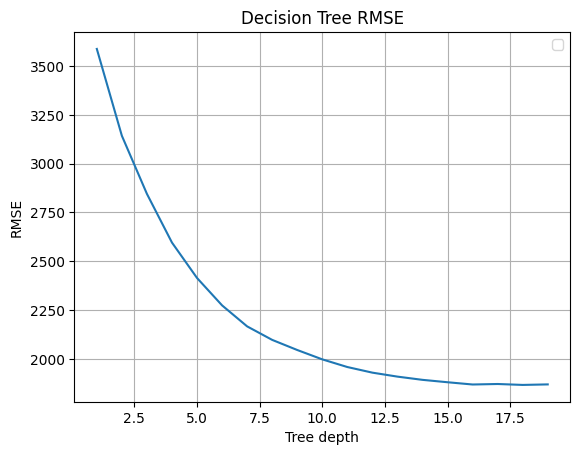

In [26]:
sns.lineplot(data = pd.DataFrame(data = tree_rmse, index = tree_dep))
plt.title('Decision Tree RMSE') 
plt.xlabel('Tree depth')
plt.ylabel('RMSE')
plt.legend('')
plt.grid()
plt.show()

### 3.2  RandomForestRegressor <a id='3.1'></a>

In [27]:
forest_tree_num = []
forest_tree_dep = []
forest_rmse = []
best_rmse = float('inf')
table_forest_rmse= pd.DataFrame(columns=['n_estim', 'max_depth', 'RMSE'])

for est in range(8, 22, 4):
        for depth in range(4, 17, 4):
                
                # Training
                start_time = time.time()
                rfr = RandomForestRegressor(random_state = 12345, n_estimators= est, max_depth=depth).fit(X_train, Y_train)
                train_time = time.time() - start_time
                
                # Predicting
                start_time = time.time()
                predicted_valid = rfr.predict(X_valid)
                pred_time = time.time() - start_time
                
                rmse = mean_squared_error(Y_valid, predicted_valid, squared=False) 
                
                forest_tree_num.append(est)
                forest_tree_dep.append(depth)
                forest_rmse.append(rmse)
                
                if rmse < best_rmse:
                        best_rmse = rmse
                        best_depth = depth
                        best_est = est
                        best_train_time = train_time
                        best_pred_time = pred_time
                
                new_row = {'n_estim': est, 'max_depth': depth, 'RMSE': f'{rmse:.2f}'}
                table_forest_rmse = pd.concat([table_forest_rmse,pd.DataFrame([new_row])], ignore_index=True)

# Save info
summary_models.loc['RandomForestRegressor'] = {'RMSE': best_rmse, 
                                        'training time':best_train_time, 
                                        'prediction time':best_pred_time}

print('Best RMSE =', f'{best_rmse:.2f}' ' | max_depth =', f'{best_depth:.0f}' ' | estim =', f'{best_est:.0f}' ' | training time =', f'{best_train_time:.2f} sec' ' | prediction time =', f'{best_pred_time:.2f} sec')
table_forest_rmse

Best RMSE = 1712.69 | max_depth = 16 | estim = 20 | training time = 71.79 sec | prediction time = 0.32 sec


,n_estim,max_depth,RMSE
0,8,4,2558.77
1,8,8,2052.28
2,8,12,1831.98
3,8,16,1732.06
4,12,4,2560.79
5,12,8,2050.18
6,12,12,1828.90
7,12,16,1723.02
8,16,4,2562.86
9,16,8,2050.07


### 3.3  LinearRegression <a id='3.3'></a>

With LinearRegression we still use the OHE (One-Hot Encoding)

In [28]:
# Training
start_time = time.time()
lr = LinearRegression().fit(X_train, Y_train)
train_time = time.time() - start_time

# Predicting
start_time = time.time()
predicted_valid = lr.predict(X_valid)
pred_time = time.time() - start_time

rmse = mean_squared_error(Y_valid, predicted_valid, squared=False)

# Save info
summary_models.loc['LinearRegression'] = {'RMSE': rmse, 
                                        'training time':train_time, 
                                        'prediction time':pred_time}

print('LinearRegression: RMSE =', f'{rmse:.2f}' ' | training time =', f'{train_time:.2f} sec' ' | prediction time =', f'{pred_time:.2f} sec')

LinearRegression: RMSE = 2654.18 | training time = 5.47 sec | prediction time = 0.11 sec


## Stage 4. Gradient boosting <a id='4'></a>

Now we are going to use three gradient boosting techniques (Catboost, XGBoost and LightGBM). The procedure will be this:
- find out what parameters are best (in terms of lowest RMSE)
- use these parameters to train the best model

### 4.1  CatBoostRegressor <a id='4.1'></a>

In [31]:
Y = df['price']
X = df.drop('price', axis=1)
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=12345)

cat_features = ['vehicletype','gearbox','model','fueltype','brand','notrepaired']

param_grid = {'depth': [4, 6, 8],
                'iterations': [10, 100, 200],
                'learning_rate': [0.4, 0.2]}

ctb_cv = GridSearchCV(CatBoostRegressor(), param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=False)

ctb_cv.fit(X_train, Y_train, cat_features=cat_features, verbose=False)

print()
best_parameters = ctb_cv.best_params_
print('\nCatBoostRegressor best parameters:', best_parameters)



CatBoostRegressor best parameters: {'depth': 8, 'iterations': 200, 'learning_rate': 0.4}


So we now use the parameters just found to develop our best CatBoostRegressor model:

In [32]:
best_ctb = CatBoostRegressor(max_depth = 8,
                            iterations = 200,
                            learning_rate = 0.4)

# Training
start_time = time.time()
best_ctb.fit(X_train, Y_train, cat_features=cat_features, verbose=False)
train_time = time.time() - start_time

# Predicting
start_time = time.time()
pred = best_ctb.predict(X_valid)
pred_time = time.time() - start_time

rmse = mean_squared_error(Y_valid, pred, squared=False)

# Save info
summary_models.loc['CatBoostRegressor'] = {'RMSE': rmse, 
                                        'training time':train_time, 
                                        'prediction time':pred_time}

print('\nBest LightGBM RMSE =', f'{rmse:.2f}',
      '| training time = 'f'{train_time:.2f} sec',
      '| predicting time = 'f'{pred_time:.2f} sec')


Best LightGBM RMSE = 1636.13 | training time = 25.76 sec | predicting time = 0.19 sec


So, we got a RMSE equal to 1636. This is the best so far but we keep trying with another gradient boosting technique.

### 4.2 XGBoostRegressor <a id='4.2'></a>

XGBoost does support categorical columns but those have to be transformed to numerical. To do so, we can use one-hot encoding.

In [33]:
Y = df_ohe['price']
X = df_ohe.drop('price', axis=1)
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=12345)

param_grid = {'max_depth': [4, 6, 8],
              'n_estimators': [10, 100, 200],
              'learning_rate': [0.4, 0.2]}

xgb_cv = GridSearchCV(XGBRegressor(), param_grid=param_grid, cv=2, scoring='neg_root_mean_squared_error')

xgb_cv.fit(X_train, Y_train)

best_parameters = xgb_cv.best_params_
print('XGBRegressor best parameters:', best_parameters)

XGBRegressor best parameters: {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200}


So we now use the parameters just found to develop our best XGBRegressor model:

In [34]:
best_xgb = XGBRegressor(max_depth = 8,
                            n_estimators = 200,
                            learning_rate = 0.2)

# Training
start_time = time.time()
best_xgb.fit(X_train, Y_train)
train_time = time.time() - start_time

# Predicting
start_time = time.time()
pred = best_xgb.predict(X_valid)
pred_time = time.time() - start_time

rmse = mean_squared_error(Y_valid, pred, squared=False)

# Save info
summary_models.loc['XGBRegressor'] = {'RMSE': rmse, 
                                        'training time':train_time, 
                                        'prediction time':pred_time}

print('\nBest XGBR RMSE =', f'{rmse:.2f}',
      '| training time = 'f'{train_time:.2f} sec',
      '| predicting time = 'f'{pred_time:.2f} sec')


Best XGBR RMSE = 1619.79 | training time = 93.02 sec | predicting time = 0.33 sec


### 4.3 LightGBMRegressor <a id='4.3'></a>

LightGBM works with categorical columns like CatBoost.

In [35]:
# Change categorical feature  "object" to "category"
cat_features = ['vehicletype','gearbox','model','fueltype','brand','notrepaired']

Y = df['price']
X = df.drop('price', axis=1)
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=12345)

param_grid = {'max_depth':[4, 6, 8],
                'n_estimators':[10, 100, 200],
                'learning_rate':[0.01, 0.1],
                'reg_alpha':[1, 2, 3]}

for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')
    
lgbm_cv = GridSearchCV(LGBMRegressor(), param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error')

lgbm_cv.fit(X_train, Y_train)

best_parameters = lgbm_cv.best_params_
print('LGBMRegressor best parameters:', best_parameters)

LGBMRegressor best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'reg_alpha': 1}


So we now use the parameters just found to develop our best LGBMRegressor model:

In [38]:
best_lgbm = LGBMRegressor(max_depth = 8,
                        n_estimators = 200,
                        learning_rate = 0.1,
                        reg_alpha = 1)

# Training
start_time = time.time()
best_lgbm.fit(X_train, Y_train)
train_time = time.time() - start_time

# Predicting
start_time = time.time()
pred = best_lgbm.predict(X_valid)
pred_time = time.time() - start_time

rmse = mean_squared_error(Y_valid, pred, squared=False)

# Save info
summary_models.loc['LGBMRegressor'] = {'RMSE': rmse, 
                                        'training time':train_time, 
                                        'prediction time':pred_time}

print('Best LightGBM RMSE =', f'{rmse:.2f}',
      '| training time = 'f'{train_time:.2f} sec',
      '| predicting time = 'f'{pred_time:.2f} sec')

Best LightGBM RMSE = 1638.84 | training time = 0.57 sec | predicting time = 0.11 sec


In [39]:
summary_models.round(2)

,RMSE,training time,prediction time
DecisionTreeRegressor,1866.44,8.15,0.13
RandomForestRegressor,1712.69,71.79,0.32
LinearRegression,2654.18,5.47,0.11
CatBoostRegressor,1636.13,25.76,0.19
XGBRegressor,1619.79,93.02,0.33
LGBMRegressor,1638.84,0.57,0.11


## Conclusion <a id='conclusion'></a>

We started our project with the aim of  developing an app that predicts the value of a used car. The 2nd hand car platoform gave us the history, technical specifications, equipment, versions and prices.

As usual the first thing we did was to explore data, graphically as well. Making a correlation matrix (that shows the little correlation between features and target), pairplots that indicate no linear relation at all, and some boxplots that allowed us to partially foresee what factors influenced the most the price of a car.

After that we preprocessesd our data to fill as much as possible the null values and trying to lose as little data as possible.

We trained three models for price prediction (DecisionTreeRegressor, RandomForestRegressor and LinearRegression), from which we got their best RMSE and understood what was the most precise method.

After that we execute three gradient boosting technique (Catboost, XGBoost and LightGBM). To check if the gradient boosting worked well we compare it with linear regression. If gradient boosting performs worse than linear regression, something has definitely gone wrong.

The model with the best  RMSE score is the XGBoost with 85 sec of training time, and 0.22 sec of prediction time. This model is the slowest compared to the rest that we train. 

The fastest model in its training and prediction is the LightGBM with 0.57 sec of training time, and 0.11 sec of prediction time, with a RMSE slightly higher than XGBoost.